## Installing the required packages

In [1]:
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install -Uqq ipdb

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 3.3 MB 42.3 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████| 895 kB 44.2 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
     |████████████████████████████████| 792 kB 8.1 MB/s 
     |████████████████████████████████| 374 kB 62.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.


## Importing required libraries

In [2]:
import os
import warnings
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

from itertools import chain
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_scheduler
from transformers.optimization import Adafactor, AdamW
from IPython.display import HTML, display

In [4]:
# Use this when working on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define the Class for Prompt Tuning

In [80]:
class T5PromptTuning(T5ForConditionalGeneration):
    def __init__(self, config):
          super().__init__(config)

    @classmethod
    def from_pretrained(cls, model_name_or_path: str, soft_prompt_path: str = None, number_tokens: int = None,
        initialize_from_vocab: bool = True, random_range: float = 0.5, **kwargs):
      
        model = super().from_pretrained(model_name_or_path, **kwargs)
  
        #  freeze the transformers model
        for param in model.parameters():
            param.requires_grad = False

        # if a saved soft prompt is loaded, use its embeddings
        if soft_prompt_path is not None: 
          model.set_soft_prompt_embeds(soft_prompt_path=soft_prompt_path)
        # else create a new soft prompt
        elif number_tokens is not None:
            print("Initializing soft prompt")
            model.initialize_soft_prompt(number_tokens=number_tokens, initialize_from_vocab=initialize_from_vocab, random_range=random_range)
        return model

    def set_soft_prompt_embeds(self, soft_prompt_path):
        self.soft_prompt = torch.load(
            soft_prompt_path, map_location=torch.device("cpu")
        )
        self.number_tokens = self.soft_prompt.shape[0]
        print(f"Set soft prompt. (number_tokens: {self.number_tokens})")

    def initialize_soft_prompt(self, number_tokens: int = 20, initialize_from_vocab: bool = True, random_range: float = 0.5):
        self.number_tokens = number_tokens
        if initialize_from_vocab:
            init_prompt_value = self.shared.weight[:number_tokens].clone().detach()
        else:
            init_prompt_value = torch.FloatTensor(number_tokens, self.config.d_model).uniform_(-random_range, random_range)

        print(init_prompt_value.shape)
        print(self.shared.weight.shape)

        # Initialize weight
        self.soft_prompt = torch.nn.parameter.Parameter(init_prompt_value)

    def get_soft_params(self):
        return self.soft_prompt

    # this method appends the learned prompt embeddings to the input ids of the input before the forward pass is calculated
    def append_learned_embedding_to_input(self, input_ids):
        inputs_embeds = self.shared(input_ids)
        
        if len(list(inputs_embeds.shape)) == 2: inputs_embeds = inputs_embeds.unsqueeze(0)

        # the shape of the tensor that will be returned will be: [batch_size, max_sequence_length, number_embeddings] -> [8, 600, 512]
        learned_embeds = self.soft_prompt.repeat(inputs_embeds.size(0), 1, 1)
        return torch.cat([learned_embeds, inputs_embeds], dim=1)

    # to make sure that padding token ids of the labels are not taken into account by the loss function
    # this method extends the labels tensor by elements that are ignored by the CrossEntropyLoss function
    # this can be done using the ignore_index value -100
    def extend_labels(self, labels, ignore_index=-100):
        if len(list(labels.shape)) == 1: labels = labels.unsqueeze(0)
        number_of_batches = labels.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+labels] that is filled with the ignore_index value (-100)
        return torch.cat([torch.full((number_of_batches, self.number_tokens), ignore_index).to(self.device), labels], dim=1)

    def extend_attention_mask(self, attention_mask):
        # prepend a new dimension (1) to the shape of attention_mask in case it is one dimensional
        if len(list(attention_mask.shape)) == 1: attention_mask = attention_mask.unsqueeze(0)

        # get the number of batches
        number_of_batches = attention_mask.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+attention_mask] that is filled with the ones
        return torch.cat([torch.full((number_of_batches, self.number_tokens), 1).to(self.device), attention_mask], dim=1)

    def save_soft_prompt(self, challenge_name, epochs, model_size, number_tokens):
        torch.save(self.soft_prompt, f'drive/MyDrive/MIwDL/soft_prompts/soft_prompt_{challenge_name}_t5_{model_size}_{epochs}_epochs_{number_tokens}.model')

## Load the Pre-trained model T5 and the tokenizer

In [58]:
import torch as nn
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()


# Prompt-tuning
# number of prompt tokens
number_prompt_tokens = 50

# If set to true, the soft prompt will be initialized from the models vocabulary
# Otherwise, it will be randomly (uniformly in a range) initialized.
random_range = 0.5
init_from_vocab = True

try:
  del inputs_train_amr
  del inputs_test_amr
  del model_t5_small
  gc.collect()
except Exception:
  pass

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

tokenizer_t5 = T5Tokenizer.from_pretrained('t5-base')

# Instantiate one T5 small model that should be trained on all the 3 datasets
#model_t5_small = T5PromptTuning.from_pretrained('t5-small', soft_prompt_path='drive/MyDrive/MIwDL/soft_prompts/soft_prompt_amr_90_epochs_2.model')
model_t5 = T5PromptTuning.from_pretrained('t5-base', number_tokens=number_prompt_tokens, initialize_from_vocab=init_from_vocab)

#moving the models to device(GPU/CPU)
model_t5.to(dev)

Running on the GPU
Tesla T4
Initializing soft prompt
torch.Size([50, 768])
torch.Size([32128, 768])


T5PromptTuning(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dropout(p=0.1,

## Preprocessing

In [67]:
load_no_duplicate_sets = True

# Load the datasets for the Web NLG 2020 challenge
train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/train/trainset_no_duplicate_inputs.csv')
test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/train/amr_train_no_duplicate_inputs.csv')
test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/test/amr_test_no_duplicate_inputs.csv')

# Load the datasets for the Web NLG 2020 challenge
#train_data_web_nlg = pd.read_csv('data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
#test_data_web_nlg = pd.read_csv('data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
#train_data_e2e = pd.read_csv('data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'data/e2e/train/trainset_no_duplicate_inputs.csv' )
#test_data_e2e = pd.read_csv('data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
#train_data_amr = pd.read_csv('data/amr/train/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'data/amr/train/amr_train_no_duplicate_inputs.csv')
#test_data_amr = pd.read_csv('data/amr/test/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'data/amr/test/amr_test_no_duplicate_inputs.csv')False)

In [68]:
# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)

test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

train_data_amr = train_data_amr.sort_values(by='input_text', ignore_index=True)
test_data_amr = test_data_amr.sort_values(by='input_text', ignore_index=True)

# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:] if not load_no_duplicate_sets else train_data_web_nlg.iloc[:len(train_data_web_nlg)-3,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:] if not load_no_duplicate_sets else test_data_web_nlg.iloc[:len(test_data_web_nlg)-7,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:] if not load_no_duplicate_sets else train_data_e2e.iloc[:len(train_data_e2e)-6,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:] if not load_no_duplicate_sets else test_data_e2e.iloc[:len(test_data_e2e)-6,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:] if not load_no_duplicate_sets else train_data_amr.iloc[:len(train_data_amr)-6,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:] if not load_no_duplicate_sets else test_data_amr.iloc[:len(test_data_amr)-3,:]

In [69]:
# Set the batch size and the number of training epochs
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 1640 --- 
--- Number of test  batches Web NLG: 74  --- 

--- Number of train batches E2E : 607 --- 
--- Number of test  batches E2E : 78  --- 

--- Number of train batches AMR : 168 --- 
--- Number of test  batches AMR : 18  --- 


In [70]:
def create_list_of_batches(batch_size, num_batches, data, tokenizer):
# Create List of batches for inputs and labels
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
#          input_batch.append('translate from Graph to Text: '+row['input_text']+'</s>')
#          label_batch.append(row['target_text']+'</s>')

          input_batch.append('translate from Graph to Text: '+row['input_text'])
          label_batch.append(row['target_text'])

        input_batch=tokenizer.batch_encode_plus(input_batch,padding=True, return_tensors='pt', return_attention_mask=True)
        label_batch=tokenizer.batch_encode_plus(label_batch,padding=True, return_tensors='pt', return_attention_mask=True)

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

inputs_train_web_nlg, \
labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_train_web_nlg,
                                              data=train_data_web_nlg,
                                              tokenizer=tokenizer_t5)
inputs_test_web_nlg, \
labels_test_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_test_web_nlg,
                                              data=test_data_web_nlg,
                                              tokenizer=tokenizer_t5)
inputs_train_e2e, \
labels_train_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_train_e2e,
                                              data=train_data_e2e,
                                              tokenizer=tokenizer_t5)
inputs_test_e2e, \
labels_test_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_test_e2e,
                                              data=test_data_e2e,
                                              tokenizer=tokenizer_t5)
inputs_train_amr, \
labels_train_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_train_amr,
                                              data=train_data_amr,
                                              tokenizer=tokenizer_t5)
inputs_test_amr, \
labels_test_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_test_amr,
                                              data=test_data_amr,
                                              tokenizer=tokenizer_t5)


## Set the Optimizer for T5

In [71]:
def optimizer_adafactor(model, 
              lr=0.6,              # default values for adafactor
              eps=(1e-30, 1e-3),    # default values for adafactor
              clip_threshold=1.0,   # default values for adafactor 
              decay_rate=-0.8,      # default values for adafactor
              beta1=None,           # default values for adafactor 
              weight_decay=1e-5,     # default values for adafactor 
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        [model.get_soft_params()],
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )
optimizer_t5 = optimizer_adafactor(model_t5)

## Training Routine Definition

In [72]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()
    
    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        #outputs = model(input_ids=inputs[i]['input_ids'], labels=labels[i]['input_ids'], attention_mask=inputs[i]['attention_mask'])
        outputs = model(inputs_embeds=model.append_learned_embedding_to_input(inputs[i]['input_ids']), labels=model.extend_labels(labels[i]['input_ids']), attention_mask= model.extend_attention_mask(inputs[i]['attention_mask']))
        
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

## Training Process

In [73]:
# Set the number of epochs to train
epochs = 4

Running epoch: 1


Epoch: 1 , Running loss: 1.146739339937524


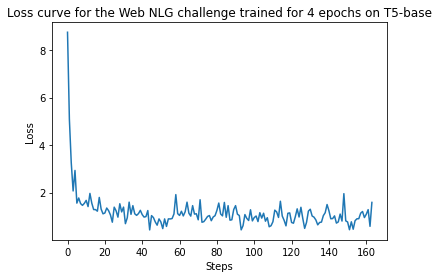

Running epoch: 2


Epoch: 2 , Running loss: 0.8792582379245176


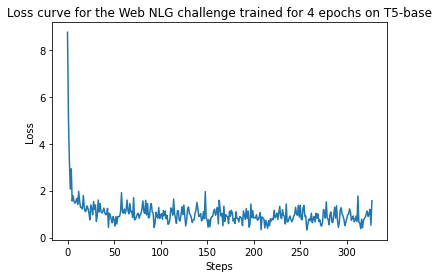

Running epoch: 3


Epoch: 3 , Running loss: 0.8277061702638138


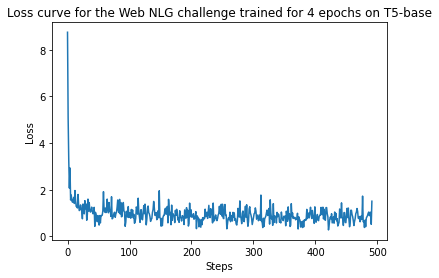

Running epoch: 4


Epoch: 4 , Running loss: 0.8084231661859809


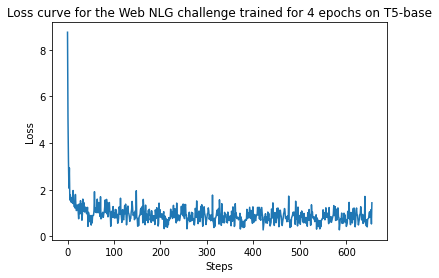

In [76]:
# Train T5 small on a mixture of all three challenges

model_t5 = trainer(model=model_t5, 
                         num_batches=number_of_batches_train_web_nlg, 
                         inputs=inputs_train_web_nlg, 
                         labels=labels_train_web_nlg,
                         optimizer=optimizer_t5,
                         challenge_name='Web NLG',
                         model_name='base')

## Evaluate a Model

In [77]:
# use this method to generate text for each test input ids, then save the predictions
# in a file 'hypothesis' for web nlg and amr to later use the official evaluation script for the 
# challenges
def make_predictions(model, inputs_test, tokenizer, challenge_name):

  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      embeds = model.append_learned_embedding_to_input(inputs_test[i]['input_ids'])
      output = tokenizer.batch_decode(model.generate(inputs_embeds=embeds,
                                                     #do_sample=True, 
                                                     max_length=400,
                                                     #top_p=0.92,
                                                     #top_k=0,
                                                     bos_token_id=0,
                                                     pad_token_id=0,
                                                     eos_token_id=1,
                                                     use_cache=True,
                                                     attention_mask=model.extend_attention_mask(inputs_test[i]['attention_mask'])
                                                     ),
                                      skip_special_tokens=True,
                                      )
      print(output)
      model_predictions.append([x.replace('<pad>','').replace('</s>','').strip() for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  
  model.train()
  with open('drive/MyDrive/MIwDL/data/' + challenge_name + '/test/prompt_tuning_hypothesis/hypothesis', 'w') as file:
    for i in range(len(model_predictions)):
      file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])
  return model_predictions

In [78]:

model_predictions = make_predictions(model=model_t5,
                         inputs_test=inputs_test_web_nlg,
                         tokenizer=tokenizer_t5,
                         challenge_name='web_nlg')

['1147 Stavropolis has an absolute magnitude of 11.5.', '1147 Stavropolis has an apoapsis of 418476000000.0. stavropolis has an apoapoapsis of 41847600000', '1147 Stavropolis was discovered in 1929.', 'Grigory Neujmin discovered 1147 Stavropolis.', '1147 Stavropolis was built on 31 July 2016.', '1147 Stavropolis has an orbital period of 1249.6.', '1147 Stavropolis has periapsis of 260855000000.0.', '1147 Stavropolis rotates for 20378.5 years.']
['11th Mississippi Infantry Monument is a contribution property.', '11th Mississippi Infantry Monument is in the United States.', 'The 11th Mississippi Infantry Monument is located in Adams County, Pennsylvania. Military Monument is located in Adams County is', '11th Mississippi Infantry Monument is in Pennsylvania.', 'Eric Flint wrote 1634: The Bayarian Crisis.', '1634: The Bayarian Crisis was preceded by DeMarce short stories in the Grantville Gazettes.', 'ALCO RS-3 was built by the American Locomotive Company.', 'Montreal locomotive works bui

## Save the Soft Prompt

In [79]:
#torch.save(model_t5_small.soft_prompt, 'drive/MyDrive/MIwDL/soft_prompts/soft_prompt_amr_120_epochs.model')
model_t5.save_soft_prompt(challenge_name='web_nlg', epochs=str(5))